In [2]:
data = pd.read_csv(r"diabetes.csv")
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
            Model Fold  Accuracy  Precision    Recall  F1-Score  TP  TN  FP  \
0   Random Forest    1  0.805195   0.730769  0.703704  0.716981  43  19   8   
1   Random Forest    2  0.753247   0.700000  0.518519  0.595745  44  14  13   
2   Random Forest    3  0.714286   0.608696  0.518519  0.560000  41  14  13   
3   Random Forest    4  0.870130   0.904762  0.703704  0.791667  48  19   8   
4   Random Forest    5  0.792208   0.761905  0.592593  0.666667  45  16  11   
5   Random Forest    6  0.727273   0.636364  0.518519  0.571429  42  14  13   
6   Random Forest    7  0.753247   0.681818  0.555556  0.612245  43  15  12   
7   Random Forest    8  0.766234   0.666667  0.666667  0.666667  41  18   9   
8   Random Forest    9  0.789474   0.678571  0.730769  0.703704  41  19   7   
9   Random Forest   10  0.723684   0.619048  0.500000  0.553191  42  13  13   
10           LSTM  N/A  0.733766   0.632653  0.574074  0.601942  82  31  23   
11            

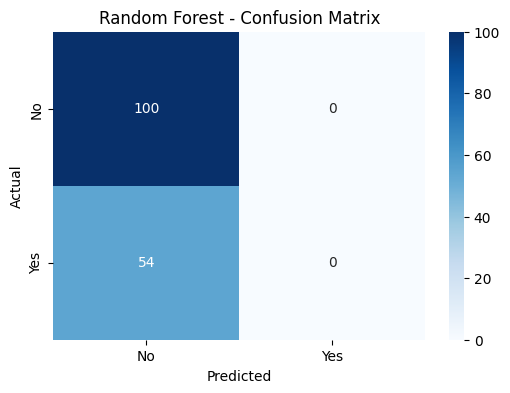

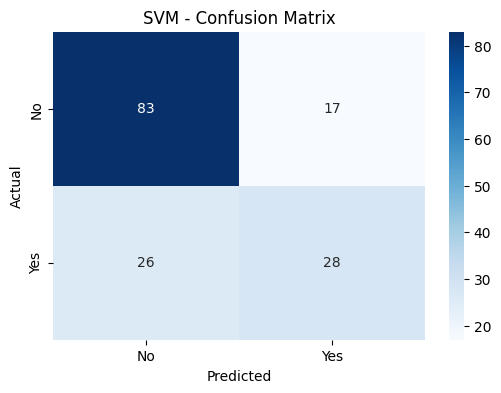

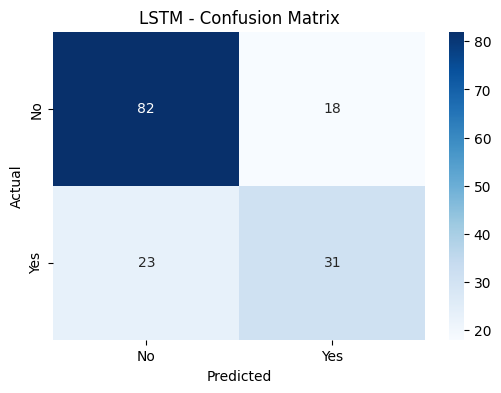

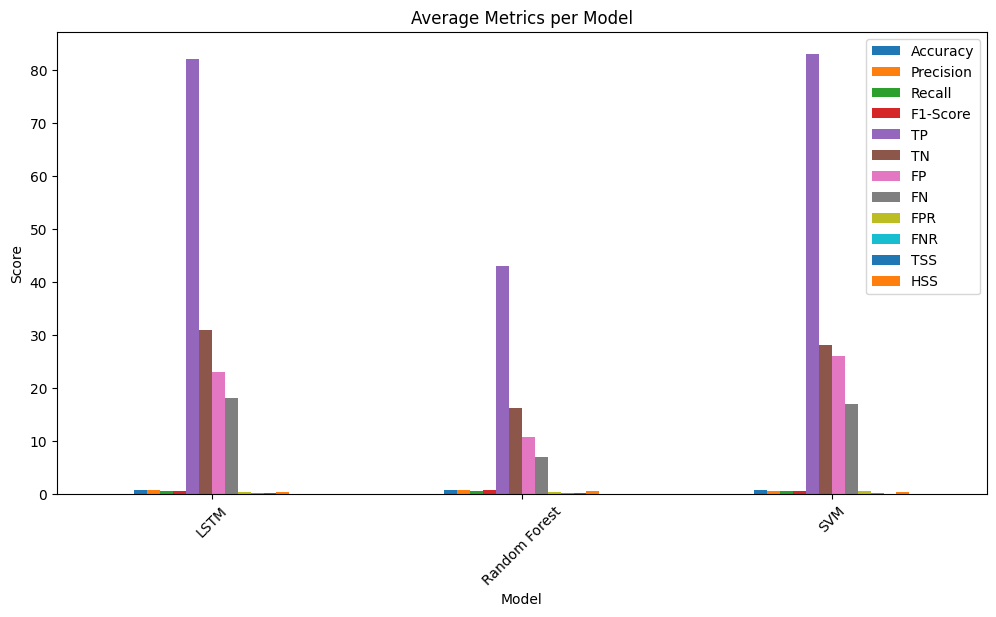


Model Comparison:
           Model  Average Accuracy  Average F1-Score  Average TSS  Average HSS
0           LSTM          0.733766          0.601942     0.148148     0.402649
1  Random Forest          0.769498          0.643829     0.201709     0.475379
2            SVM          0.720779          0.565657     0.037037     0.362411

The best model for this dataset based on Average Accuracy is: Random Forest with an Accuracy of 0.7695.
Models saved as 'rf_model.pkl', 'lstm_model.h5', and 'svm_model.pkl'


In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import joblib

# Load the dataset
data = pd.read_csv(r"diabetes.csv")

# Separate features (X) and target (y)
X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values   

# Function to calculate metrics
def calculate_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = cm.ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = recall - fpr
    hss = (2 * (tp * tn - fp * fn)) / (
        (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    ) if (tp + fn + fp + tn) > 0 else 0
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "TSS": tss,
        "HSS": hss,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "FPR": fpr,
        "FNR": fnr
    }

# Results dictionary
results = {
    'Model': [],
    'Fold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'FPR': [],
    'FNR': [],
    'TSS': [],
    'HSS': []
}

# 10-Fold Cross-Validation for Random Forest
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Random Forest Classifier (Cross-validation)
rf_model = RandomForestClassifier(random_state=42)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    metrics = calculate_metrics(y_test, y_pred)
    for metric, value in metrics.items():
        results[metric].append(value)
    results['Model'].append('Random Forest')
    results['Fold'].append(fold)
    fold += 1

# Standardize data for LSTM and SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split for LSTM and SVM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# LSTM Model
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
metrics = calculate_metrics(y_test, y_pred_lstm)
for metric, value in metrics.items():
    results[metric].append(value)
results['Model'].append('LSTM')
results['Fold'].append('N/A')  # LSTM doesn't use cross-validation

# SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
metrics = calculate_metrics(y_test, y_pred_svm)
for metric, value in metrics.items():
    results[metric].append(value)
results['Model'].append('SVM')
results['Fold'].append('N/A')  # SVM doesn't use cross-validation

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Calculate average metrics for each model and compare
average_metrics = results_df.groupby('Model').mean(numeric_only=True)

# Compare models based on average metrics
comparison = {
    "Model": [],
    "Average Accuracy": [],
    "Average F1-Score": [],
    "Average TSS": [],
    "Average HSS": []
}

for model in average_metrics.index:
    comparison["Model"].append(model)
    comparison["Average Accuracy"].append(average_metrics.loc[model, "Accuracy"])
    comparison["Average F1-Score"].append(average_metrics.loc[model, "F1-Score"])
    comparison["Average TSS"].append(average_metrics.loc[model, "TSS"])
    comparison["Average HSS"].append(average_metrics.loc[model, "HSS"])

comparison_df = pd.DataFrame(comparison)


# Plot Confusion Matrices
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for each model
plot_confusion_matrix(y_test, rf_model.predict(X_test), 'Random Forest')
plot_confusion_matrix(y_test, y_pred_svm, 'SVM')
plot_confusion_matrix(y_test, y_pred_lstm, 'LSTM')

# Visualizing Metric Comparison
average_metrics = results_df.groupby('Model').mean(numeric_only=True)

average_metrics.plot(kind='bar', figsize=(12, 6), title="Average Metrics per Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Print model comparison
print("\nModel Comparison:")
print(comparison_df)



# Identify the best model based on Average Accuracy
best_model_row = comparison_df.loc[comparison_df['Average Accuracy'].idxmax()]
best_model_name = best_model_row['Model']
best_model_accuracy = best_model_row['Average Accuracy']



# Add a line to print which model is best
best_model_summary = f"\nThe best model for this dataset based on Average Accuracy is: {best_model_name} with an Accuracy of {best_model_accuracy:.4f}."
print(best_model_summary)

# Save models
joblib.dump(rf_model, os.path.join(output_dir, "rf_model.pkl"))
lstm_model.save(os.path.join(output_dir, "lstm_model.h5"))
joblib.dump(svm_model, os.path.join(output_dir, "svm_model.pkl"))

print("Models saved as 'rf_model.pkl', 'lstm_model.h5', and 'svm_model.pkl'")
